In [1]:
import sys
sys.path.append('../')
import random
import numpy as np
import math
import quimb.tensor as qtn
import tnad.smpo as smpo
from timeit import default_timer as timer

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
mpo = smpo.SpacedMatrixProductOperator.rand(n=8, spacing=1)

In [ ]:
mpo.norm()

#### Check normalization

In [ ]:
mpo.normalize(insert=0)

In [ ]:
mpo.norm()

#### Check trace

In [ ]:
mpo.trace(left_inds=mpo.upper_inds, right_inds=mpo.lower_inds)

#### Check canonization

In [ ]:
mpo.canonize(0)

In [ ]:
mpo.tensors[0]

In [ ]:
mpo.tensors[0].norm()

In [ ]:
(mpo.tensors[1] & mpo.tensors[1]) ^ all

In [ ]:
mpo.norm()

In [ ]:
mpo.canonize((1,4))

In [ ]:
mpo.norm()

In [ ]:
mpo.tensors[0].norm()

In [ ]:
mpo.calc_current_orthog_center()

#### Check MPS&MPO

In [ ]:
#mps = qtn.MPS_rand_state(L=8, bond_dim=4)
mps = qtn.MPS_rand_computational_state(L=8) # all 0 and 1s

In [ ]:
(mpo&mps).draw(show_tags=False, show_inds=True, output_inds=[*mpo.lower_inds, *mpo.upper_inds])

In [ ]:
((mpo&mps)^mpo.site_tag(0)^mpo.site_tag(1)^mpo.site_tag(2)^mpo.site_tag(3)^mpo.site_tag(4)^mpo.site_tag(5)^mpo.site_tag(6)^mpo.site_tag(7)).draw()

In [ ]:
mpo_copy = mpo.copy(deep=True)
mpo_copy.draw()

### Optimization

In [2]:
from tqdm import tqdm
#import embeddings as e
import tnad.FeatureMap as fm
import itertools
from matplotlib import pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [ ]:
from losses import loss_miss, loss_reg
from gradients import gradient_miss, gradient_reg

In [ ]:
lamda_init = 2*10^(-3)
decay_rate=0.01
alpha = 0.5 # regularization
N_features = 49

In [ ]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
# class = 1 -> inliers
train_data = train_X[train_y==1][:64]
np.random.shuffle(train_data)

# preprocessing
data = []
for sample in train_data:
    sample_tf = tf.constant(sample)
    sample_tf = tf.reshape(sample_tf, [1, 28, 28, 1])
    max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
       strides=(4, 4), padding='same')
    sample = max_pool_2d(sample_tf).numpy().reshape(7, 7)
    data.append(sample/255)

In [ ]:
train_data = np.array(data)
train_data.shape

In [ ]:
N_features = train_data.shape[1]*train_data.shape[2]
N_features

In [ ]:
batch_size = 32
n_iters = int(train_data.shape[0]/batch_size)
train_data_batched = np.array(np.split(train_data, n_iters))
print(train_data_batched.shape)

In [ ]:
import importlib
importlib.reload(fm)

In [ ]:
fm.trigonometric(0.5)

In [ ]:
phi, _ = fm.embed(train_data_batched[0][1].flatten(), fm.trigonometric)

In [ ]:
train_data_batched[0][1].flatten()

In [ ]:
phi.tensors

In [ ]:
n_epochs = 1

In [ ]:
# init P
P_orig = smpo.SpacedMatrixProductOperator.rand(n=N_features, spacing=3, init_func='normal', scale=0.5)

In [ ]:
P = P_orig.copy(deep=True)

In [ ]:
P_orig.draw(show_tags='all', font_size_inner=15, figsize=(15,15))

In [ ]:
# @dask.delayed(nout=2)
def calculate_loss_and_grad(sample, P_ref, P, sites, N_features):
    # create MPS for input sample
    phi, _ = fm.embed(sample.flatten(), fm.trigonometric)

    #calculate loss
    loss_miss_batch = loss_miss(phi, P_ref)

    #calculate gradient
    grad_miss = gradient_miss(phi, P_ref, P, sites, N_features)
    
    return loss_miss_batch, grad_miss

In [ ]:
def get_loss_and_grad(train_data_batched):
    #grad_miss=0; loss_miss_batch=0
    loss_miss_batch=[]; grad_miss=[]
        
    for sample in train_data_batched:
        lmb, gm = calculate_loss_and_grad(sample, P_ref, P, sites, N_features)
        # loss
        loss_miss_batch.append(lmb)
        # gradient
        grad_miss.append(gm)
    return sum(loss_miss_batch), sum(grad_miss)

In [ ]:
loss_array = []
for epoch in range(n_epochs):
    for it in range(n_iters):
        sweeps = itertools.chain(zip(list(range(0,N_features-1)), list(range(1,N_features))), reversed(list(zip(list(range(1,N_features)),list(range(0,N_features-1))))))
        for sweep_it, sites in enumerate(sweeps):
            [sitel, siter] = sites
            site_tags = [P.site_tag(site) for site in sites]
            # canonize P with root in sites
            ortog_center = sites
            P.canonize(sites, cur_orthog=ortog_center)
            P_ref = P.copy(deep=True)
            # pop site tensor
            [origl, origr] = P.select_tensors(site_tags, which="any")
            
            bond_ind_removed = P.bond(site_tags[0], site_tags[1])
            tensor_orig = origl & origr ^ all

            #virtual bonds
            #    left
            if sitel == 0 or (sitel == N_features-1 and sitel>siter): vindl = []
            elif sitel>0 and sitel<siter: vindl = [P.bond(sitel-1, sitel)]
            else: vindl = [P.bond(sitel, sitel+1)]
            #    right
            if siter == N_features - 1 or (siter == 0 and siter<sitel): vindr = []
            elif siter < N_features-1 and siter>sitel: vindr = [P.bond(siter, siter+1)]
            else: vindr = [P.bond(siter-1, siter)]

            P.delete(site_tags, which="any")
            
            loss_miss_batch, grad_miss = get_loss_and_grad(train_data_batched[it])
            # loss_miss_batch, grad_miss = out1.compute(), out2.compute()
            
            # total loss
            loss = (1/batch_size)*(loss_miss_batch) + loss_reg(P_ref, alpha)
            print(f'epoch: {epoch}, iteration: {it}, sweep id: {sweep_it} -> loss={loss}')
            loss_array.append(loss)

            # gradient of loss miss
            grad_miss.drop_tags()
            grad_miss.add_tag(site_tags[0]); grad_miss.add_tag(site_tags[1])
            # gradient of loss reg
            grad_regular = gradient_reg(P_ref, P, alpha, sites, N_features)
            if grad_regular != 0:
                grad_regular.drop_tags()
                grad_regular.add_tag(site_tags[0]); grad_regular.add_tag(site_tags[1])
            # total gradient
            total_grad = (1/batch_size)*grad_miss + grad_regular

            # update tensor
            if epoch < 10:
                tensor_new = tensor_orig - lamda_init*total_grad
            else:
                lamda = lamda_init*math.pow((1 - decay_rate/100),epoch)
                tensor_new = tensor_orig - lamda*total_grad

            # normalize updated tensor
            tensor_new.normalize(inplace=True)

            # split updated tensor in 2 tensors
            lower_ind = [f'b{sitel}'] if f'b{sitel}' in P.lower_inds else []
            [tensorl, tensorr] = tensor_new.split(get="tensors", left_inds=[*vindl, P.upper_ind(sitel), *lower_ind], bond_ind=bond_ind_removed, max_bond=4)

            # link new tensors to P back
            for site, tensor in zip(sites, [tensorl, tensorr]):
                tensor.drop_tags()
                tensor.add_tag(P.site_tag(site))
                P.add_tensor(tensor)

In [ ]:
import quimb as qu
qu.save_to_disk(P, 'SMPO.pkl')

In [ ]:
np.save('loss_array.npy', loss_array)

In [ ]:
plt.figure(figsize=(12,4))
plt.xlabel("epoch")
plt.ylabel("loss", color="tab:blue")
plt.plot(range(0, len(loss_array)), loss_array)
plt.show()

### Global update

In [ ]:
# args
train_size = 1024
batch_size = 32
strides = (2,2)
pool_size = (2,2)
padding = 'same'
reduced_shape = (14,14)
opt_procedure = 'global_update_costfuncnorm'
spacing = 8
n_epochs = 10
alpha = 0.4
lamda_init = 2e-3
decay_rate = 0.01
expdecay_tol = 10
bond_dim = 5
init_func = 'normal'
scale_init_p = 0.5

In [ ]:
from tnad.optimization import train_SMPO, load_mnist_train_data, data_preprocessing
import tnad.procedures as p

train_data = load_mnist_train_data(train_size=train_size)
data = data_preprocessing(train_data, strides=strides, pool_size=pool_size, padding=padding, reduced_shape=reduced_shape)

if opt_procedure == 'local_update_sweep_dyncanonization_renorm':
        opt_procedure = p.local_update_sweep_dyncanonization_renorm
elif opt_procedure == 'global_update_costfuncnorm':
    opt_procedure = p.global_update_costfuncnorm

P, loss_array = train_SMPO(data, spacing, n_epochs, alpha, opt_procedure, lamda_init, decay_rate, expdecay_tol, bond_dim, init_func, scale_init_p, batch_size)

#### Test P model

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import quimb as qu

In [ ]:
P = qu.load_from_disk('SMPO.pkl')

In [ ]:
def anomaly_score(phi, P):
    phi_orig_renamed = phi.reindex({f'k{site}':f'k_{site}' for site in range(phi.nsites)})
    P_orig_renamed = P.reindex({f'k{site}':f'k_{site}' for site in range(P.nsites)})
    return math.pow((math.log((phi_orig_renamed.H&P_orig_renamed.H&P&phi)^all) - 1), 2)

In [ ]:
def get_roc_data(qcd, bsm):
    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.nan_to_num(np.concatenate((bsm, qcd)))
    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)
    return fpr_loss, tpr_loss

In [ ]:
_ , (test_X, test_y) = mnist.load_data()

In [ ]:
test_data=test_X[test_y!=1][:1000]

In [ ]:
test_data.shape

In [ ]:
valid_data = test_X[test_y==1][:1000]
valid_data.shape

In [ ]:
# preprocessing - anomalies
anomalies = []
for sample in test_data:
    sample_tf = tf.constant(sample)
    sample_tf = tf.reshape(sample_tf, [1, 28, 28, 1])
    max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
       strides=(4, 4), padding='same')
    sample = max_pool_2d(sample_tf).numpy().reshape(7, 7)
    anomalies.append(sample/255)

In [ ]:
# preprocessing - normal
normal_data = []
for sample in valid_data:
    sample_tf = tf.constant(sample)
    sample_tf = tf.reshape(sample_tf, [1, 28, 28, 1])
    max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
       strides=(4, 4), padding='same')
    sample = max_pool_2d(sample_tf).numpy().reshape(7, 7)
    normal_data.append(sample/255)

In [ ]:
anomalies_adscore=[]
for sample in anomalies:
    phi, _ = fm.embed(sample.flatten(), fm.trigonometric)
    l = anomaly_score(phi, P)
    # loss
    anomalies_adscore.append(l)

In [ ]:
normal_adscore=[]
for sample in normal_data:
    phi, _ = fm.embed(sample.flatten(), fm.trigonometric)
    l = anomaly_score(phi, P)
    # loss
    normal_adscore.append(l)

In [ ]:
fpr, tpr = get_roc_data(np.array(normal_adscore), np.array(anomalies_adscore))
auc_value = auc(fpr, tpr)

In [ ]:
auc_value

## Plot output of jax training

In [3]:
loss = np.load('../examples/train_loss_test1.npy')

In [4]:
loss

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

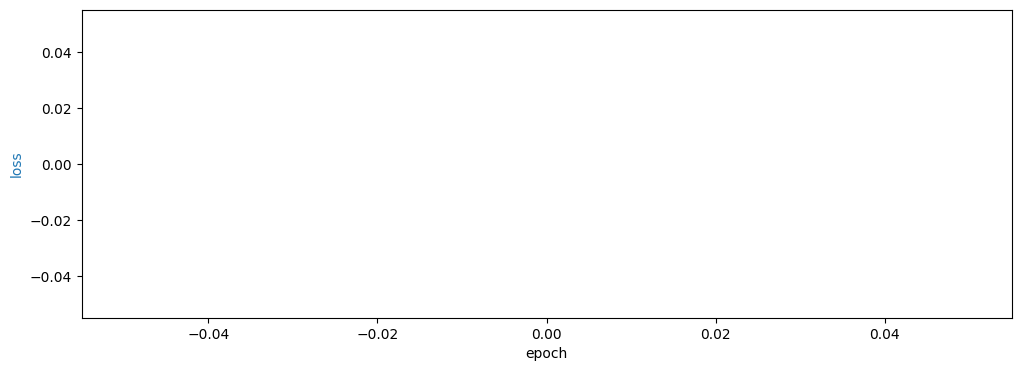

In [5]:
plt.figure(figsize=(12,4))
plt.xlabel("epoch")
plt.ylabel("loss", color="tab:blue")
plt.plot(range(0, len(loss)), loss)
plt.show()